<a href="https://colab.research.google.com/github/chan-kh/Music-Sentiment-Analysis/blob/main/LSTM_2outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import os
import datetime
from google.colab import drive

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Bidirectional

from math import sqrt
from scipy.stats.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [48]:
drive.mount("/content/drive")
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Sentiment/features_60frames_allsongs.csv')
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,song_id,frame_num,zcr,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,melspectrogram,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_stft_0,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,chroma_stft_11,chroma_cqt_0,chroma_cqt_1,chroma_cqt_2,chroma_cqt_3,chroma_cqt_4,chroma_cqt_5,chroma_cqt_6,chroma_cqt_7,chroma_cqt_8,chroma_cqt_9,chroma_cqt_10,chroma_cqt_11,chroma_cens_0,chroma_cens_1,chroma_cens_2,chroma_cens_3,chroma_cens_4,chroma_cens_5,chroma_cens_6,chroma_cens_7,chroma_cens_8,chroma_cens_9,chroma_cens_10,chroma_cens_11,tonnetz_0,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,valence,arousal
0,2,0,0.157715,0.000011,5604.262879,3246.069688,9549.975586,18.349374,0.283305,0.000000,-636.134705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.654255,0.699066,0.261531,0.874848,1.000000,0.333313,0.812421,0.488101,0.413135,0.640419,0.671442,0.490904,0.725918,0.250459,0.284098,0.647150,0.349017,0.147453,0.501239,0.074669,0.070883,0.633342,0.184297,0.136420,0.700169,0.030602,0.209675,0.828279,0.124886,0.257948,1.000000,0.071105,0.309559,0.798000,0.076693,0.276441,-0.134078,0.072852,-0.134683,0.086125,0.060471,0.042898,-0.073341,-0.109386
1,2,1,0.051758,0.096817,1443.667160,2057.611806,3036.181641,27.017306,0.003931,1.576688,-120.319748,129.464996,-4.253306,22.214062,8.163963,16.415987,15.152133,7.878392,-6.823561,-0.831550,-7.218902,-4.558928,-1.807601,12.948887,-9.162554,-3.758020,-5.506585,-1.227700,-4.439484,1.684063,0.528904,0.624552,0.263783,0.891966,0.850903,0.331133,1.000000,1.000000,0.408033,0.713866,0.681263,0.480444,0.245905,0.378263,0.278916,0.160639,0.397115,0.147040,0.285743,0.536704,0.072041,0.314144,0.652729,0.144099,0.269362,0.637670,0.218737,0.382769,0.677961,0.263132,0.424450,0.649488,0.317883,0.517798,0.579528,0.282752,-0.088692,0.052331,-0.112961,0.075804,0.041915,0.033029,-0.074661,-0.114942
2,2,2,0.101562,0.096426,2348.097128,2387.006355,4941.870117,22.434103,0.013857,0.152583,-107.915352,76.319107,-14.175928,45.124214,1.209538,7.516734,-5.023264,6.480774,-0.513962,8.108901,-0.198636,-3.022716,2.078595,4.819644,-16.200150,-3.348299,-5.746615,-9.680576,-17.688511,-5.846364,0.190785,0.290683,0.265836,0.206553,0.217986,0.329024,0.491271,0.576434,0.402986,1.000000,0.924618,0.469653,0.706139,0.605435,0.273279,0.307669,0.224213,0.146400,0.107266,0.206321,0.073380,0.222554,0.297425,0.151825,0.408395,0.409732,0.227828,0.563377,0.734764,0.268284,0.755202,1.000000,0.326054,0.528056,0.687259,0.288720,-0.034494,0.031843,-0.070020,0.068549,0.021691,0.023202,-0.074077,-0.116413
3,2,3,0.062500,0.086847,1692.187106,1872.280637,3219.213867,21.295763,0.004178,0.224268,-148.255432,121.565720,-36.703545,33.151939,4.518500,5.197342,-8.610166,4.267920,8.706326,-17.273952,-11.429454,4.515498,-7.324573,4.467141,-13.720921,-3.195490,-3.931114,-7.317858,-15.654930,-15.824336,0.245845,0.300974,0.267710,0.523842,0.578168,0.326966,1.000000,0.842026,0.397746,0.846539,1.000000,0.458391,0.477668,0.673670,0.267148,0.095004,0.189054,0.145584,0.031817,0.101448,0.075003,0.024125,0.114284,0.159790,0.044276,0.137589,0.237066,0.215029,0.300263,0.273559,0.177739,0.341496,0.334054,0.110806,0.207098,0.294537,-0.013095,0.020309,-0.055259,0.034349,0.011610,0.012032,-0.078154,-0.118613
4,2,4,0.120605,0.113167,2632.895857,2453.043616,5329.467773,18.914987,0.025196,1.035493,-71.919838,76.267471,-28.003765,15.988888,4.667567,35.548042,-6.664427,-5.128408,9.827440,-1.635414,-5.240368,-1.569069,-1.458279,7.581460,-16.175152,-6.295955,-9.435411,-3.781498,-8.782184,-7.635081,0.223808,0.355715,0.269517,0.202841,0.376315,0.324933,0.624933,0.684395,0.392219,1.000000,1.000000,0.446547,0.319092,0.

In [49]:
df.shape

(104640, 74)

In [50]:
df =df.iloc[np.random.permutation(np.arange(104640).reshape(-1,60)).ravel()]

In [51]:
# df.to_csv('/content/drive/My Drive/Colab Notebooks/Sentiment/shuffled_data.csv',index=False)

In [52]:
df.shape

(104640, 74)

In [53]:
df.pop('song_id')
df.pop('frame_num')

77640     0
77641     1
77642     2
77643     3
77644     4
         ..
24535    55
24536    56
24537    57
24538    58
24539    59
Name: frame_num, Length: 104640, dtype: int64

In [54]:
y = df.loc[:,'valence':'arousal']
print(y.shape)
y.head()

(104640, 2)


,valence,arousal
77640,0.304,0.369
77641,0.307,0.334
77642,0.307,0.330
77643,0.313,0.337
77644,0.285,0.344


In [55]:
df.pop('valence')
df.pop('arousal')

77640    0.369000
77641    0.334000
77642    0.330000
77643    0.337000
77644    0.344000
           ...   
24535   -0.336522
24536   -0.336522
24537   -0.337449
24538   -0.339131
24539   -0.339131
Name: arousal, Length: 104640, dtype: float64

In [56]:
df.head()


,zcr,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,melspectrogram,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_stft_0,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,chroma_stft_11,chroma_cqt_0,chroma_cqt_1,chroma_cqt_2,chroma_cqt_3,chroma_cqt_4,chroma_cqt_5,chroma_cqt_6,chroma_cqt_7,chroma_cqt_8,chroma_cqt_9,chroma_cqt_10,chroma_cqt_11,chroma_cens_0,chroma_cens_1,chroma_cens_2,chroma_cens_3,chroma_cens_4,chroma_cens_5,chroma_cens_6,chroma_cens_7,chroma_cens_8,chroma_cens_9,chroma_cens_10,chroma_cens_11,tonnetz_0,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5
77640,0.132324,0.024669,1477.636761,1838.985442,2540.917969,8.203295,0.004616,0.002006,-484.522980,95.268822,1.764593,6.518457,34.900707,21.415401,-0.528042,-5.957627,5.123166,13.123142,-3.386053,-12.294834,7.116289,11.757257,-4.902506,-7.183062,-3.020082,-3.659946,3.685781,4.222351,0.499727,0.783831,0.474018,0.382268,0.544593,0.508094,0.325520,0.680481,0.342568,0.338432,0.268316,0.196332,0.219726,0.331834,0.200098,0.170053,0.445230,0.168556,0.320402,0.438848,0.141919,0.410888,0.923345,0.230238,0.625430,0.361896,0.294360,1.000000,1.000000,0.229520,0.636207,0.565555,0.158512,0.507369,0.517150,0.234936,0.150197,0.129260,-0.040957,-0.030217,0.022756,0.022296
77641,0.109863,0.083269,2709.032692,2603.511457,5577.099609,21.593237,0.026613,3.286030,-115.785141,66.830460,-5.715693,39.065399,10.830339,25.295828,-0.284443,1.855588,9.157700,15.234893,-2.143625,1.491561,0.680903,-2.286056,-14.654966,-11.492694,-7.799317,3.336190,3.042935,-16.434231,0.143964,0.348278,0.473824,0.114758,0.409260,0.513251,0.061295,0.259918,0.345887,0.166943,0.385838,0.198450,0.109532,0.270204,0.203309,0.057356,0.296175,0.166991,0.140644,0.407470,0.139591,0.578404,0.627074,0.224789,1.000000,1.000000,0.291764,0.824725,0.668489,0.223135,0.216491,0.419277,0.156600,0.100118,0.314940,0.233172,0.042250,0.019820,-0.024098,0.014231,0.005489,-0.005992
77642,0.068359,0.077767,2053.890101,2199.507571,3843.676758,18.126777,0.005098,0.659434,-165.560989,82.560959,-13.019189,55.559753,17.262129,-0.289376,17.046997,4.805817,5.473624,24.305386,-2.688711,-6.442607,-0.425842,-0.862550,4.521096,0.703876,-16.802643,-7.712189,2.187905,-3.440493,0.778366,0.800366,0.473479,1.000000,1.000000,0.517983,0.675026,0.493285,0.349129,0.126529,0.153760,0.200235,0.032609,0.168349,0.205921,0.037740,0.168614,0.165506,0.021385,0.137521,0.137555,0.095407,0.202276,0.219892,0.691853,0.330699,0.289294,0.204722,0.186040,0.217257,0.074472,0.174161,0.154915,0.215378,0.257131,0.231443,0.024748,0.028812,-0.049817,0.042212,0.009967,-0.007594
77643,0.065430,0.056142,2266.056929,2694.034684,5307.934570,31.111375,0.008914,0.685626,-190.803986,81.215836,-7.421595,20.797331,35.984383,20.090511,8.288561,5.916316,1.776661,21.574722,-1.276429,-4.638777,2.933753,15.317495,1.036695,6.719216,-10.096843,-9.654547,-6.565480,-6.703116,0.176719,0.513084,0.472944,0.317366,0.525625,0.522299,0.618085,0.669694,0.352181,1.000000,1.000000,0.201877,0.729007,0.920036,0.208163,0.285297,0.598527,0.164076,0.354008,0.300056,0.135771,0.157575,0.306947,0.215533,0.159628,0.361055,0.286934,0.114824,0.334224,0.211901,0.056241,0.362964,0.153515,0.185527,0.187000,0.229787,0.038821,0.019697,-0.025029,0.081799,-0.004733,-0.013464
77644,0.068848,0.084631,1995.792992,2691.704229,5318.701172,17.925444,0.009728,0.279819,-140.159012,107.985786,16.366348,10.963785,12.321772,9.410452,-4.698711,10.649832,-6.733243,2.558616,4.159822,7.585886,-4.736413,-1.855888,-4.985592,-1.166024,-14.898453,1.850972,-1.710667,5.044908,0.572314,0.702881,0.472164,0.845733,1.000000,0.526272,1.000000,0.878940,0.355036,0.715709,0.606265,0.203409,0.293769,0.347037,0.210197,0.183996,0.341543,0.162671,0.176131,0.429517,0.134297,0.239193,0.399417,0.211779,0.373741,0.4

In [57]:
# df_mean = df.mean()
# df_std = df.std()

# df = (df - df_mean) / df_std


In [58]:
# print(type(df))

In [59]:
features = df.to_numpy()
y = y.to_numpy()

In [60]:
print(features.shape)
print(y.shape)

(104640, 70)
(104640, 2)


In [61]:
features = features.reshape(1744,60,70)
y = y.reshape(1744,60,2)

In [62]:
train_X , train_y = features[0:1098] , y[0:1098]
val_X, val_y = features[1098:1220] , y[1098:1220]
test_X , test_y = features[1220:1744] , y[1220:1744]
# val_X , val_y = features [1569:1744] , valence[0:1220]

In [63]:
print("train_X :" , train_X.shape , "train_y shape:" , train_y.shape)
print("test_X :" , test_X.shape , "test_y shape:" , test_y.shape)
print("val_X :" , val_X.shape , "val_y shape:" , val_y.shape)


train_X : (1098, 60, 70) train_y shape: (1098, 60, 2)
test_X : (524, 60, 70) test_y shape: (524, 60, 2)
val_X : (122, 60, 70) val_y shape: (122, 60, 2)


In [64]:
model = Sequential()

# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(64,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(32,return_sequences=True, input_shape=(60,70))))
# model.add(Bidirectional(LSTM(16,return_sequences=True, input_shape=(60,70))))
# model.add(Bidirectional(LSTM(8,return_sequences=True, input_shape=(60,70))))




model.add(Dense(2))
model.compile(loss='mse', optimizer='adam')

In [65]:
history = model.fit(train_X, train_y, epochs=500, validation_data=(val_X, val_y), verbose=2, shuffle=False)


Epoch 1/500
35/35 - 2s - loss: 0.1546 - val_loss: 0.0564
Epoch 2/500
35/35 - 1s - loss: 0.0636 - val_loss: 0.0500
Epoch 3/500
35/35 - 1s - loss: 0.0559 - val_loss: 0.0496
Epoch 4/500
35/35 - 1s - loss: 0.0521 - val_loss: 0.0451
Epoch 5/500
35/35 - 1s - loss: 0.0498 - val_loss: 0.0448
Epoch 6/500
35/35 - 1s - loss: 0.0483 - val_loss: 0.0448
Epoch 7/500
35/35 - 1s - loss: 0.0477 - val_loss: 0.0448
Epoch 8/500
35/35 - 1s - loss: 0.0471 - val_loss: 0.0429
Epoch 9/500
35/35 - 1s - loss: 0.0462 - val_loss: 0.0436
Epoch 10/500
35/35 - 1s - loss: 0.0459 - val_loss: 0.0432
Epoch 11/500
35/35 - 1s - loss: 0.0452 - val_loss: 0.0418
Epoch 12/500
35/35 - 1s - loss: 0.0442 - val_loss: 0.0420
Epoch 13/500
35/35 - 1s - loss: 0.0443 - val_loss: 0.0417
Epoch 14/500
35/35 - 1s - loss: 0.0441 - val_loss: 0.0426
Epoch 15/500
35/35 - 1s - loss: 0.0438 - val_loss: 0.0417
Epoch 16/500
35/35 - 1s - loss: 0.0434 - val_loss: 0.0433
Epoch 17/500
35/35 - 1s - loss: 0.0430 - val_loss: 0.0425
Epoch 18/500
35/35 - 1s

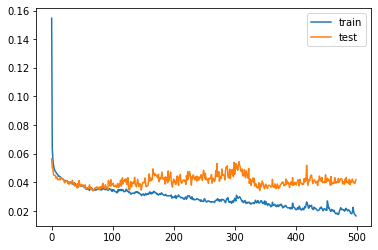

<Figure size 432x288 with 0 Axes>

In [66]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.savefig("training loss 350epochs_5layers")

In [67]:
history.history
print('overall loss' , np.mean(history.history['loss']))
print('overall val_loss' , np.mean(history.history['val_loss']))

overall loss 0.0292668852545321
overall val_loss 0.040981590881943704


In [68]:
predicted_y = model.predict(test_X)


In [69]:
print(predicted_y.shape)
print(test_y.shape)

(524, 60, 2)
(524, 60, 2)


In [70]:
predicted_valence = predicted_y[:,:,0]
predicted_arousal = predicted_y[:,:,1]
test_valence = test_y[:,:,0]
test_arousal = test_y[:,:,1]

In [71]:
# for i in range(1):
  # print(predicted_valence[i])
  # print(predicted_arousal[i])
  # print(test_valence[i])
  # print(test_arousal[i])

In [72]:
predicted_valence = predicted_valence.reshape(31440,)
test_valence = test_valence.reshape(31440,)
predicted_arousal = predicted_arousal.reshape(31440,)
test_arousal = test_arousal.reshape(31440,)

In [73]:
def metrics(y_true,y_pred,name):
  print(name,"")
  mae = mean_absolute_error(y_true,y_pred)
  rmse = sqrt(mean_squared_error(y_true,y_pred))
  r2 = r2_score(y_true,y_pred)
  pearson_corr = pearsonr(y_true,y_pred)
  spearman_corr = spearmanr(y_true,y_pred)
  
  print('RMSE : ',rmse)
  print('Pearson : ',pearson_corr)
  print('MAE : ',mae)
  print('R2 : ',r2)
  print('Spearman : ',spearman_corr,'\n')


In [74]:
def graph_results(x,y,title, xlim=-1, ylim=-1):
  #x and y are variables ( y_pred vs y_true )
  #Important
  plt.scatter(x,y,s=15)

  # if xlim != -1: plt.xlim([0, xlim])
  # if ylim != -1: plt.ylim([0, ylim])
  # plt.gca().set_ylim([1.5,7.5])
  # plt.gca().set_xlim([1.5,9])
  #Fix 
  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.title((title))
  # m, b = np.polyfit(x, y, 1)
  # plt.plot(x, m*x + b, color='red')  
  plt.savefig(title)

  plt.show()

valence 
RMSE :  0.22274177933684178
Pearson :  (0.4194116079579163, 0.0)
MAE :  0.1785161833607248
R2 :  0.05353709932398987
Spearman :  SpearmanrResult(correlation=0.4105263047195764, pvalue=0.0) 



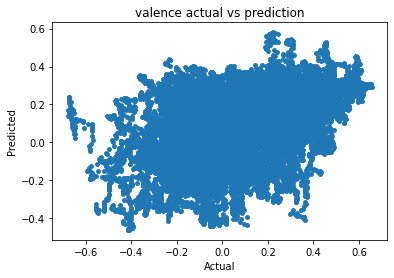

In [75]:
metrics(test_valence,predicted_valence,'valence')
graph_results(test_valence,predicted_valence,'valence actual vs prediction')


arousal 
RMSE :  0.18708171050471503
Pearson :  (0.7638859650166554, 0.0)
MAE :  0.14844456410307902
R2 :  0.5796148075037768
Spearman :  SpearmanrResult(correlation=0.7665185417349579, pvalue=0.0) 



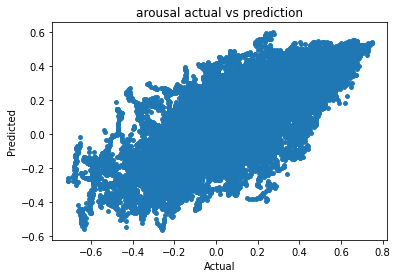

In [76]:
metrics(test_arousal,predicted_arousal,'arousal')
graph_results(test_arousal,predicted_arousal,'arousal actual vs prediction')